In [1]:
# !pip install -U transformers nbdev fastcore accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [2]:
#|default_exp train

In [3]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [4]:
#|export
import torch, torch.nn.functional as F, random, wandb, time, os
# import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel, AutoencoderKL
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed, get_constant_schedule_with_warmup
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler, IterableDataset
from functools import partial
from types import SimpleNamespace
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel
from collections import defaultdict


from utils import (
    # generate,
    plot_density, 
    pil_add_text, 
    kl_encode,
    kl_decode,
    # latent_to_PIL, 
    make_grid, 
    # dcae_scalingf, 
    encode_prompt,
    pil_clipscore, 
    free_memory, 
    get_rnd_sigmas,
    get_sigma_schedule,
)

seed = 42
set_seed(seed)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
#|export
def load_models(text_encoder, transformer_config, ae, dtype, device):
    transformer = SanaTransformer2DModel.from_config(transformer_config).to(device).to(dtype)
    te = AutoModel.from_pretrained(text_encoder, torch_dtype=dtype).to(device)
    tok = AutoTokenizer.from_pretrained(text_encoder, torch_dtype=dtype)
    dcae = AutoencoderKL.from_pretrained(ae, torch_dtype=dtype).to(device)

    if debug:
        print(f"Transformer parameters: {sum(p.numel() for p in transformer.parameters()) / 1e6:.2f}M")
        print(f"DCAE parameters: {sum(p.numel() for p in dcae.parameters()) / 1e6:.2f}M")

    return transformer, te, tok, dcae

def add_random_noise(latents, dist, timesteps=1000):
    bs = latents.size(0)
    noise = torch.randn_like(latents)
    sigmas = get_rnd_sigmas(bs, dist=dist).to(latents.device)  # floats 0-1 of dist specified in train_config
    timesteps = (sigmas * timesteps).to(latents.device)   # yes, `timesteps = sigmas * 1000`, let's keep it simple
    sigmas = sigmas.view([latents.size(0), *([1] * len(latents.shape[1:]))])
    
    latents_noisy = (1 - sigmas) * latents + sigmas * noise # (1-noise_level) * latent + noise_level * noise

    return latents_noisy.to(latents.dtype), noise, timesteps

def eval_loss(dataloader_eval, testing=False):
    losses = []

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(dataloader_eval), "eval_loss", total=len(dataloader_eval)):
        latents = latents * dcae.config.scaling_factor
        latents_noisy, noise, t = add_random_noise(latents, dist=train_config.sigma_sampling)
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
        if testing: break
        # dataloader (=ShapeBatchingDataset) by design goes on forever -> stop once we have roughly seen all of them
        if batch_num>len(dataloader_eval): break
    return sum(losses)/len(losses)

def generate(
    prompt, 
    transformer,
    tokenizer, 
    text_encoder, 
    dcae,
    neg_prompt="",
    guidance_scale=None,
    latent_dim=None, 
    num_steps=100, 
    latent_seed=None,
    flow_shift=1.0,
    return_xps=False
    ):
    
    assert guidance_scale is None or neg_prompt is not None, "Neg. prompt has to be specified with CFG"
    
    do_cfg = guidance_scale is not None
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dcae.dtype).to(dcae.device)
    sigmas, timesteps = get_sigma_schedule(num_steps, flow_shift=flow_shift)
    xps = []
    
    prompt_encoded, prompt_atnmask = encode_prompt([prompt, neg_prompt] if do_cfg else prompt, tokenizer, text_encoder)
    
    for t, sigma_prev, sigma_next, steps_left in zip(timesteps, sigmas[:-1], sigmas[1:], range(num_steps, 0, -1)):
        t = t[None].to(dcae.dtype).to(dcae.device)
        with torch.no_grad():
            noise_pred = transformer(
                torch.cat([latent] * 2) if do_cfg else latent, 
                timestep=torch.cat([t] * 2) if do_cfg else t, 
                encoder_hidden_states=prompt_encoded, 
                encoder_attention_mask=prompt_atnmask, 
                return_dict=False
            )[0]
        
        if do_cfg:
            noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

        if return_xps:
            x0 = latent + steps_left * (sigma_next - sigma_prev) * noise_pred 
            xps.append(x0)
        latent = latent + (sigma_next - sigma_prev) * noise_pred 
    if return_xps:
        return kl_decode(latent / dcae.config.scaling_factor, dcae), latent_to_PIL(torch.cat([x0 / dcae.config.scaling_factor for x0 in xps]), dcae)
    else:
        return kl_decode(latent / dcae.config.scaling_factor, dcae)



In [6]:
#|export
dtype = torch.bfloat16
device = "cuda" 
debug = True
ddp = True

model_config = SimpleNamespace(
    text_encoder = "answerdotai/ModernBERT-large",
    transformer_config = "transformer_Sana-DiT-B-MBERT-large-EQ-SDXL-VAE.json",
    ae = "KBlueLeaf/EQ-SDXL-VAE",
)

data_config = SimpleNamespace(
    dataset = "imagenet1k_eqsdxlvae_latents_withShape",
    col_label = "label",
    col_latent = "latent",
    split_train = "train",
    split_eval = "validation",
)

train_config = SimpleNamespace(
    lr = 3e-4,
    bs = 80,
    # epochs = 100,
    steps_train = 200_000,
    steps_warmup = 1000,
    steps_log = 10,
    # steps per epoch: 14850 -- /4 --> 3712
    # steps_eval = 20_000,
    steps_eval = 2_000,
    steps_save = 4_000,
    timesteps_training = 1000,
    sigma_sampling = "normal",  # beta uniform normal
    log_wandb = True,
    wandb_project = "Hana",
    wandb_run = "Sana-DiT-B-{size:.2f}M_{ds}_LR-{lr}_BS-{bs}_{ts_sampling}-TS-{ts}_{ws}x{device}",
    upload_model_to = "g-ronimo/hana-alpha33"
)

eval_config = SimpleNamespace(
    prompts = [
        "a collection of comic books on a table",
        "a green plant with a green stem",
        "an airplane in the sky",
        "two fighter jets on the red sky",
        "a blonde girl",
        "a red car",
        "a blue car",
        "a cheeseburger on a white plate", 
        "a bunch of bananas on a wooden table", 
        "a white tea pot on a wooden table", 
        "an erupting volcano with lava pouring out",
    ],
    seeds = [6945, 4009, 1479, 8141, 3441], # seeds for latent generation
    inference_config = dict(
        num_steps = 20, 
        guidance_scale = 2,
        # SDXL VAE f=8, [.., 28, 36] => 288x224px image (h/w from tensor->img mixed up, not sure why)
        latent_dim = [1, 4, 28, 36]  
    )
)

In [7]:
#|export

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def custom_collate(batch):
    captions = [item['caption'] for item in batch]
    ae_latents = [item['vae_latent'] for item in batch]
    ae_latent_shapes = [item['latent_shape'] for item in batch]

    return {
        'caption': captions,
        'ae_latent': ae_latents,
        'ae_latent_shape': ae_latent_shapes
    }
    
class ShapeBatchingDataset(IterableDataset):
    def __init__(self, hf_dataset, batch_size, tokenizer, text_enc, ddp=False, num_workers=2, seed=42, buffer_multiplier=20, ):
        self.text_enc, self.tokenizer =  text_enc, tokenizer
        self.dataset = hf_dataset
        self.batch_size = batch_size
        self.seed = seed
        self.buffer_multiplier = buffer_multiplier
        self.prompt_len = 50
        self.ddp = ddp

        if ddp:
            world_size = dist.get_world_size()
            self.num_batches = len(hf_dataset) // (batch_size * world_size)
        else:
            self.num_batches = len(hf_dataset) // batch_size      

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        epoch = 0 
        
        while True:
            if self.ddp: 
                sampler = DistributedSampler(self.dataset, shuffle=True, seed=self.seed+epoch)
            else: 
                sampler = RandomSampler(self.dataset, generator=torch.manual_seed(self.seed+epoch))
            
            self.dataloader = DataLoader(
                self.dataset, self.batch_size * 2, sampler=sampler, prefetch_factor=5, num_workers=2, collate_fn=custom_collate
            )
            
            shape_batches = defaultdict(lambda: {'caption': [], 'ae_latent': []})
            for batch in self.dataloader:
                caption = batch['caption']
                ae_latent = batch['ae_latent']
                ae_latent_shape = batch['ae_latent_shape']

                for i in range(len(caption)):
                    shape_key = tuple(ae_latent_shape[i])
                    shape_batches[shape_key]['caption'].append(caption[i])
                    shape_batches[shape_key]['ae_latent'].append(ae_latent[i])

                    # If enough samples are accumulated for this shape, yield a batch
                    if len(shape_batches[shape_key]['caption']) == self.batch_size:
                        batch = self.prepare_batch(shape_batches[shape_key], shape_key)
                        yield batch
                        shape_batches[shape_key]['caption'] = []
                        shape_batches[shape_key]['ae_latent'] = []
            epoch += 1

    def prepare_batch(self, samples, latent_shape):
        captions = samples["caption"]
        ae_latents = torch.Tensor(samples["ae_latent"])
        # not 100% sure what's happenning here
        ae_latents = ae_latents.to(torch.uint8).view(torch.float8_e5m2).to(dtype).to(device)
        caption_embs, caption_atnmasks = self.encode_prompts(captions)

        return captions, ae_latents, caption_embs, caption_atnmasks

    def encode_prompts(self, prompts):
        prompts_tok = self.tokenizer(
            prompts, padding="max_length", truncation=True, max_length=self.prompt_len, return_tensors="pt"
        )
        with torch.no_grad():
            prompts_encoded = self.text_enc(**prompts_tok.to(self.text_enc.device))
        return prompts_encoded.last_hidden_state, prompts_tok.attention_mask


In [8]:
# DON'T EXPORT
ddp = False

In [9]:
#|export
if ddp:
    dist.init_process_group(backend='nccl')
    is_master = dist.get_rank() == 0  
    world_size = dist.get_world_size()
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    debug = debug and is_master
else:
    # Running on single GPU or in notebook
    is_master = True
    world_size = 1
    local_rank = 0

transformer, text_encoder, tokenizer, dcae = load_models(
    text_encoder = model_config.text_encoder,
    transformer_config = model_config.transformer_config,
    ae = model_config.ae,
    dtype = dtype,
    device = device
)
if ddp:
	transformer = DistributedDataParallel(transformer, device_ids=[local_rank])

ds = load_from_disk(data_config.dataset)

dataloader_train = ShapeBatchingDataset(
    ds[data_config.split_train], text_enc=text_encoder, tokenizer=tokenizer, batch_size=train_config.bs, ddp=ddp
)
dataloader_eval = ShapeBatchingDataset(
    # ddp = false, we want a non-distributed sampler for eval which is done on master only
    # batch_size = twice the train batch_size since we don't compute gradients here
    ds[data_config.split_eval], text_enc=text_encoder, tokenizer=tokenizer, batch_size=train_config.bs * 2, ddp=False
)

optimizer = torch.optim.AdamW(transformer.parameters(), lr=train_config.lr)

lr_scheduler = get_constant_schedule_with_warmup(optimizer, train_config.steps_warmup)

wandb_run = train_config.wandb_run.format(
    size=sum(p.numel() for p in transformer.parameters())/1e6, 
    lr=train_config.lr, 
    bs=train_config.bs, 
    ts=train_config.timesteps_training,
    ts_sampling=train_config.sigma_sampling.upper(),
    device=device,
    ds=data_config.dataset.split("/")[1].split("-")[0] if "/" in data_config.dataset else data_config.dataset,
    ws=world_size,
)

steps_epoch = len(dataloader_train)
if is_master: 
    print(f"steps per epoch: {steps_epoch}")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Transformer parameters: 116.05M
DCAE parameters: 83.65M
steps per epoch: 14850


W0305 09:18:53.955000 131159908419136 torch/_inductor/compile_worker/subproc_pool.py:126] SubprocPool unclean exit


Sigma distribution:


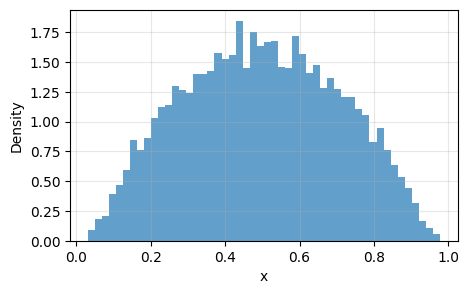

Testing noising:


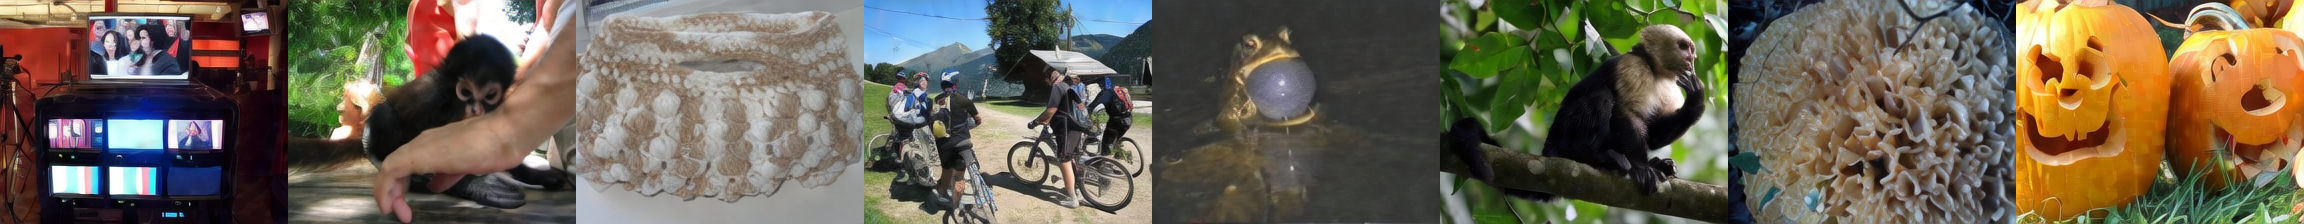

timesteps rounded [449, 272, 348, 479, 444, 376, 764, 328]


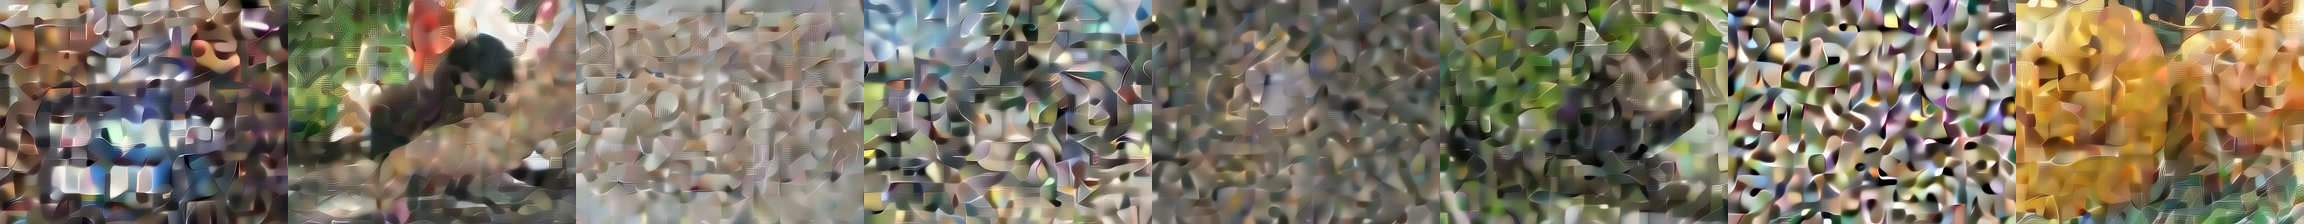

Eval prompts:
[(0, 'a collection of comic books on a table'), (1, 'a green plant with a green stem'), (2, 'an airplane in the sky'), (3, 'two fighter jets on the red sky'), (4, 'a blonde girl'), (5, 'a red car'), (6, 'a blue car'), (7, 'a cheeseburger on a white plate'), (8, 'a bunch of bananas on a wooden table'), (9, 'a white tea pot on a wooden table'), (10, 'an erupting volcano with lava pouring out')]
Inspecting first batch


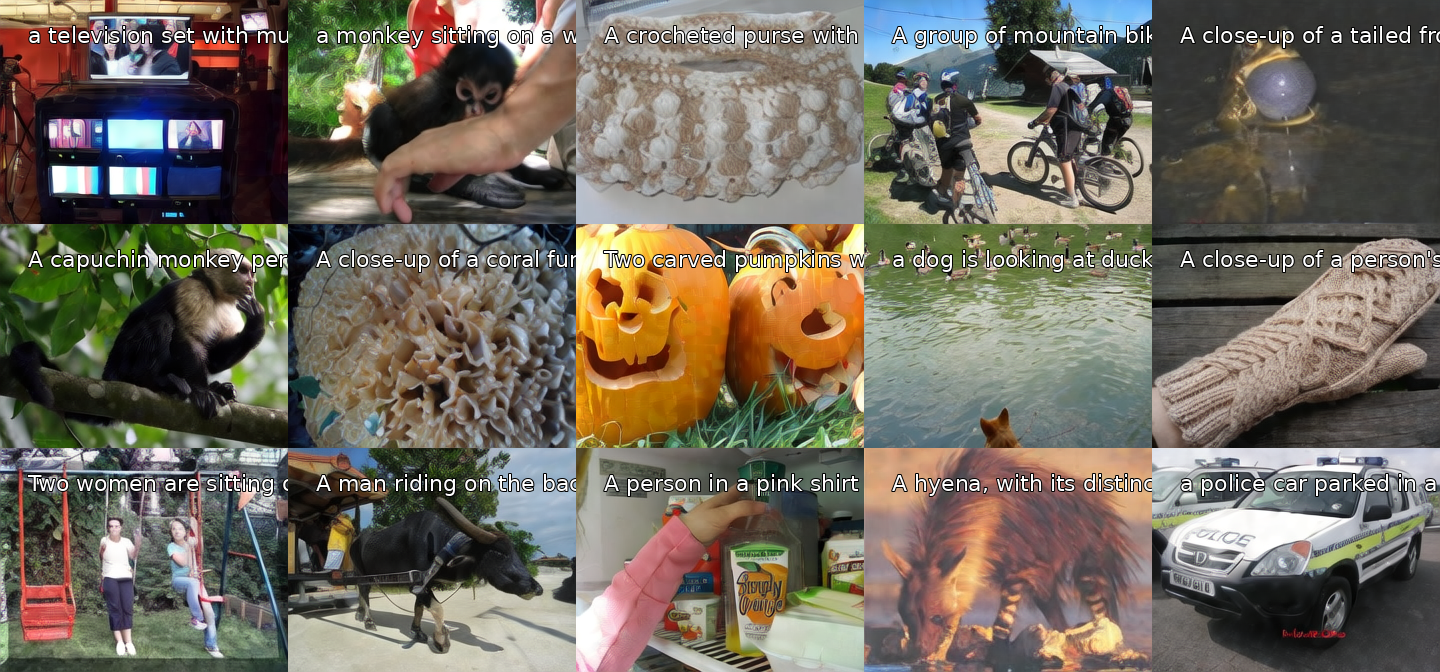

Testing generate


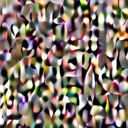

Testing eval loss


eval_loss:   0%|                                        | 0/307 [00:02<?, ?it/s]


2.203125
Testing eval images and clip score


eval_images: 100%|██████████████████████████████| 11/11 [00:04<00:00,  2.52it/s]


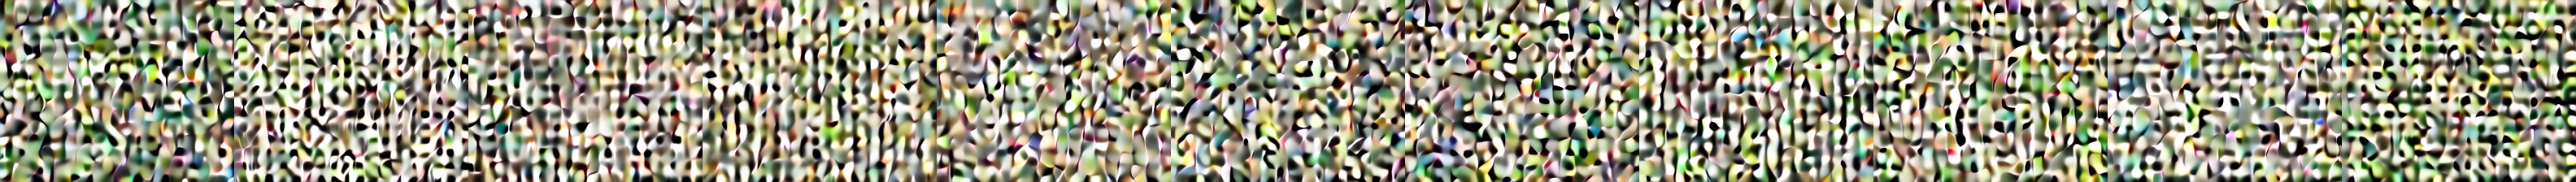

20.655759811401367


In [10]:
# DONT EXPORT
if is_master: 
    print("Sigma distribution:")
    sigmas = get_rnd_sigmas(10_000, train_config.sigma_sampling)
    plot_density(sigmas)

    print("Testing noising:")
    def test_noising():
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader_train))
        # latents=latents.to(dtype).to(device)
        latent=latents[0:8,:] * dcae.config.scaling_factor
        display(
            make_grid(
                [kl_decode(l[None,] / dcae.config.scaling_factor,dcae) for l in latent]
            )
        )
        
        latent_noisy, noise, timesteps = add_random_noise(latent, dist=train_config.sigma_sampling)
        
        print("timesteps rounded", list(map(round, timesteps.tolist())))
        display(
            make_grid(
                [kl_decode(l[None,] / dcae.config.scaling_factor,dcae) for l in latent_noisy]
            )
        )
        # display(make_grid(latent_to_PIL(latent_noisy / dcae.config.scaling_factor,dcae)))
    test_noising()

    print("Eval prompts:")
    print(list(enumerate(eval_config.prompts)))
    
    print("Inspecting first batch")
    def show_first_batch(dataloader):
        labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
        # latents=latents.to(dtype).to(device)
        images = [pil_add_text(kl_decode(latent[None, :], dcae), str(label)) for label, latent in zip(labels[:20], latents[:20])]
        display(make_grid(images[:15], 3, 5))
    show_first_batch(dataloader_train)
    
    print("Testing generate")
    display(generate("horse", transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config).resize((128,128)))
    
    print("Testing eval loss")
    print(eval_loss(dataloader_eval, testing=True))
    
    print("Testing eval images and clip score")
    images = [
        generate(p, transformer, tokenizer, text_encoder, dcae, **eval_config.inference_config) 
        for p in tqdm(eval_config.prompts, "eval_images")
    ]
    display(make_grid(images))
    print(pil_clipscore(images, eval_config.prompts))

# Train

In [2]:
import nbdev; nbdev.export.nb_export(__session__)

In [12]:
#|export

free_memory()

if is_master and train_config.log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(
        project=train_config.wandb_project, 
        name=wandb_run
    ).log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()
free_memory()

while step < train_config.steps_train:
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader_train:
        latents = latents * dcae.config.scaling_factor
        latents_noisy, noise, t = add_random_noise(latents, dist = train_config.sigma_sampling)
        v_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
        loss = F.mse_loss(v_pred, noise - latents) # flow target

        # Optimizer step
        optimizer.zero_grad()    
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()

        # Log step
        if is_master and step>0 and step % train_config.steps_log == 0:
            lr = lr_scheduler.get_last_lr()[0]
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / train_config.steps_log * 1000
            sample_count = step * train_config.bs * world_size
            sample_tp = train_config.bs * train_config.steps_log * world_size / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.2f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, lr: {lr:.5f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if train_config.log_wandb: 
                wandb.log({"loss_train": loss_train, "lr": lr, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": sample_count, "epoch": step / steps_epoch})
            last_step_time = time.time()

        # Eval step
        if is_master and step>0 and step % train_config.steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(dataloader_eval)
            sample_count = step * train_config.bs * world_size

            # try different seeds for generating eval images
            images_eval = [
                generate(
                    p, transformer, tokenizer, text_encoder, dcae, latent_seed=seed, **eval_config.inference_config
                ) 
                for seed in tqdm(eval_config.seeds, "eval_images")
                for p in eval_config.prompts
            ]
            clipscore = pil_clipscore(images_eval, eval_config.prompts * len(eval_config.seeds))
            # add labels before logging the images
            images_eval = make_grid([
                pil_add_text(img, eval_config.prompts[i % len(eval_config.prompts)]) 
                for i, img in enumerate(images_eval)
            ], rows=len(eval_config.seeds), cols=len(eval_config.prompts))
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if train_config.log_wandb: 
                wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(images_eval), "step": step, "sample_count": sample_count, "epoch": step / steps_epoch})
            transformer.train()        

        step += 1
    
    if ddp: torch.distributed.barrier()  # sync before save? don't know, let's be safe
    if is_master and step % train_config.steps_save == 0:
        if ddp: transformer.module.save_pretrained(f"cp_step-{step}")
        else: transformer.save_pretrained(f"cp_step-{step}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 10, epoch: 0.00, train loss: 2.3750, grad_norm: 11.62, lr: 0.00000, 746.70ms/step, 107.14samples/sec
step 20, epoch: 0.00, train loss: 2.1250, grad_norm: 9.69, lr: 0.00001, 592.93ms/step, 134.92samples/sec
step 30, epoch: 0.00, train loss: 2.0625, grad_norm: 5.88, lr: 0.00001, 534.80ms/step, 149.59samples/sec
step 40, epoch: 0.00, train loss: 2.0312, grad_norm: 2.88, lr: 0.00001, 538.40ms/step, 148.59samples/sec
step 50, epoch: 0.00, train loss: 1.9375, grad_norm: 2.28, lr: 0.00002, 583.18ms/step, 137.18samples/sec
step 60, epoch: 0.00, train loss: 1.8516, grad_norm: 2.55, lr: 0.00002, 536.62ms/step, 149.08samples/sec
step 70, epoch: 0.00, train loss: 1.8516, grad_norm: 2.06, lr: 0.00002, 535.26ms/step, 149.46samples/sec
step 80, epoch: 0.01, train loss: 1.8125, grad_norm: 2.33, lr: 0.00002, 583.92ms/step, 137.01samples/sec
step 90, epoch: 0.01, train loss: 1.8359, grad_norm: 2.55, lr: 0.00003, 540.09ms/step, 148.12samples/sec
step 100, epoch: 0.01, train loss: 1.6484, grad_norm: 

eval_loss: 308it [02:22,  2.16it/s]                                             
eval_images: 100%|████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]


step 100, eval loss: 1.6819, clipscore: 19.73
step 110, epoch: 0.01, train loss: 1.6016, grad_norm: 1.84, lr: 0.00003, 17892.65ms/step, 4.47samples/sec
step 120, epoch: 0.01, train loss: 1.4062, grad_norm: 1.92, lr: 0.00004, 585.39ms/step, 136.66samples/sec
step 130, epoch: 0.01, train loss: 1.3516, grad_norm: 1.32, lr: 0.00004, 537.14ms/step, 148.94samples/sec
step 140, epoch: 0.01, train loss: 1.1641, grad_norm: 2.14, lr: 0.00004, 535.85ms/step, 149.30samples/sec
step 150, epoch: 0.01, train loss: 1.1328, grad_norm: 1.05, lr: 0.00005, 589.57ms/step, 135.69samples/sec
step 160, epoch: 0.01, train loss: 1.0703, grad_norm: 1.35, lr: 0.00005, 533.30ms/step, 150.01samples/sec
step 170, epoch: 0.01, train loss: 1.0859, grad_norm: 1.23, lr: 0.00005, 533.11ms/step, 150.06samples/sec
step 180, epoch: 0.01, train loss: 1.0234, grad_norm: 1.39, lr: 0.00005, 591.38ms/step, 135.28samples/sec
step 190, epoch: 0.01, train loss: 1.0234, grad_norm: 1.00, lr: 0.00006, 540.57ms/step, 147.99samples/sec


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x774bf36ab8b0>>
Traceback (most recent call last):
  File "/home/g/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Process Process-8:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/usr/lib/python3.10/threading.py", line 1096,

KeyboardInterrupt: 

In [ ]:
#|export
if ddp: torch.distributed.barrier()

if is_master and train_config.upload_model_to:
    wandb.finish()
    transformer.module.push_to_hub(train_config.upload_model_to)

if ddp: dist.destroy_process_group()